In [25]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import pathlib

In [26]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [27]:
data_dir = "gdrive/My Drive/vehicle_images"

In [28]:
batch_size = 32
img_height = 180
img_width = 180
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 4333 files belonging to 4 classes.
Using 3467 files for training.
Found 4333 files belonging to 4 classes.
Using 866 files for validation.
['bus', 'motorcycle', 'plane', 'train']


(32, 180, 180, 3)
(32,)


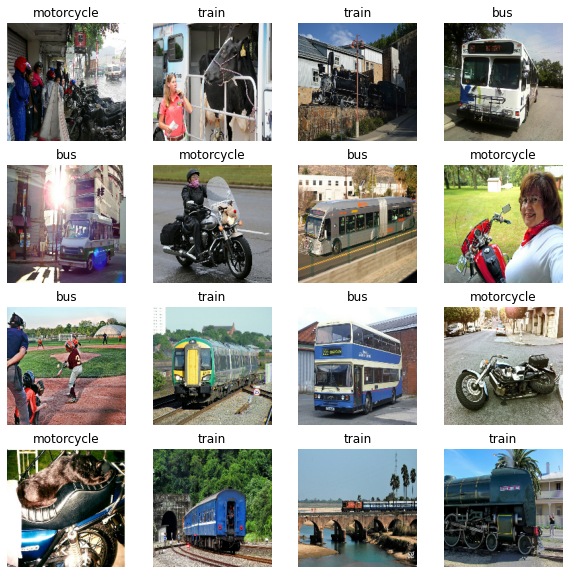

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

In [30]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
  
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [31]:
num_classes = 4

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

In [32]:
'''tf.keras.layers.Conv2D(filters=20,
                       kernel_size=(3,3),
                       strides=(1, 1), 
                       padding="valid",
                       data_format=None,
                       dilation_rate=(1, 1),
                       groups=1,
                       activation=None,use_bias=True,
                       kernel_initializer="glorot_uniform",
                       bias_initializer="zeros")'''

'tf.keras.layers.Conv2D(filters=20,\n                       kernel_size=(3,3),\n                       strides=(1, 1), \n                       padding="valid",\n                       data_format=None,\n                       dilation_rate=(1, 1),\n                       groups=1,\n                       activation=None,use_bias=True,\n                       kernel_initializer="glorot_uniform",\n                       bias_initializer="zeros")'

In [33]:
epochs = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
109/109 [==============================] - 6s 54ms/step - loss: 1.2694 - accuracy: 0.4272 - val_loss: 1.0465 - val_accuracy: 0.5866
Epoch 2/10
109/109 [==============================] - 3s 24ms/step - loss: 0.9932 - accuracy: 0.5950 - val_loss: 0.9540 - val_accuracy: 0.6224
Epoch 3/10
109/109 [==============================] - 3s 24ms/step - loss: 0.8495 - accuracy: 0.6692 - val_loss: 0.9349 - val_accuracy: 0.6270
Epoch 4/10
109/109 [==============================] - 3s 24ms/step - loss: 0.6976 - accuracy: 0.7352 - val_loss: 0.9857 - val_accuracy: 0.6097
Epoch 5/10
109/109 [==============================] - 3s 23ms/step - loss: 0.5304 - accuracy: 0.7975 - val_loss: 1.1096 - val_accuracy: 0.6062
Epoch 6/10
109/109 [==============================] - 3s 24ms/step - loss: 0.3546 - accuracy: 0.8817 - val_loss: 1.4234 - val_accuracy: 0.5635
Epoch 7/10
109/109 [==============================] - 3s 24ms/step - loss: 0.2753 - accuracy: 0.9138 - val_loss: 1.5329 - val_accuracy: 0.5716

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

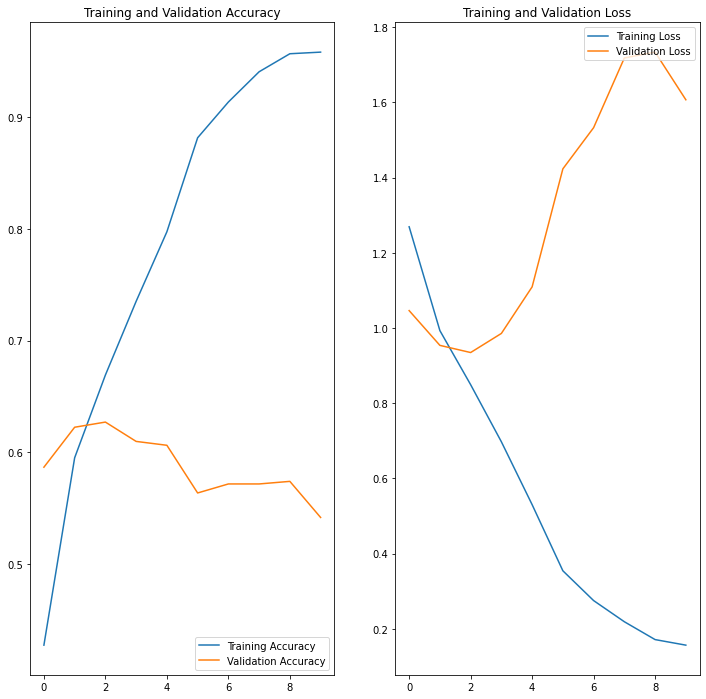

In [35]:
plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

(32, 180, 180, 3)
(32,)


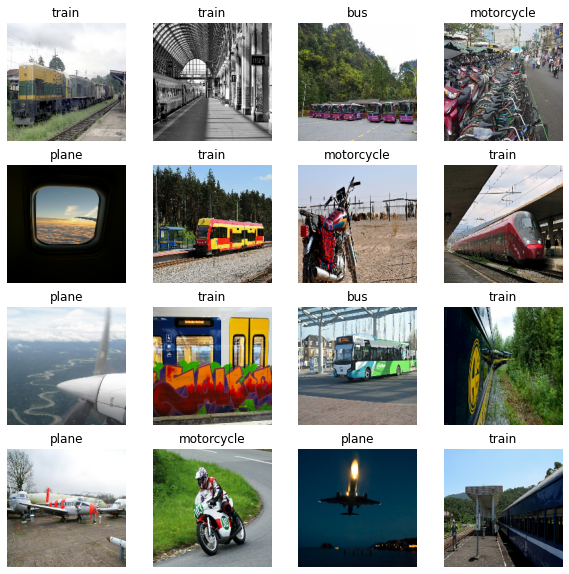

In [36]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(16):
        ax=plt.subplot(4, 4, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
for image_batch,labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break
        

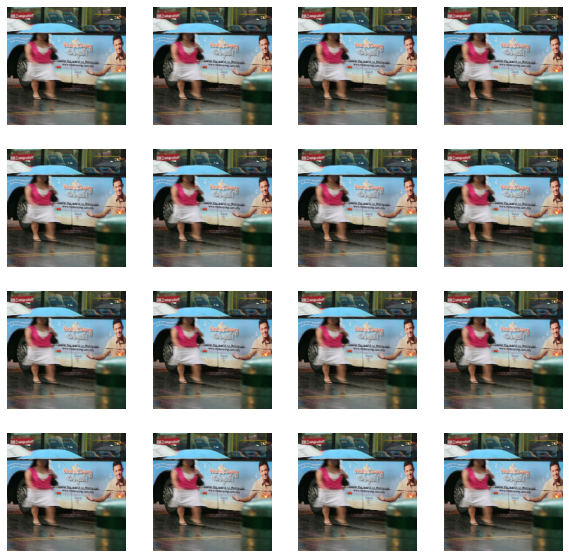

In [37]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),])

for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [38]:
IMG_SIZE = (180, 180)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape = IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


image_batch,label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 6, 6, 1280)


In [39]:
base_model.trainable = False
base_model.summary()


global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(4)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 90, 90, 32)   864         ['input_3[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 90, 90, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 90, 90, 32)   0           ['bn_Conv1[0][

In [40]:
inputs = tf.keras.Input(shape = (180, 180, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training = False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

len(model.trainable_variables)

initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

print('initial loss: {:.2f}'.format(loss0))
print('initial accuracy: {:.2f}'.format(accuracy0))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 180, 180, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 180, 180, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 6, 6, 1280)       2257984   
 ional)                                                          
                                                           

In [41]:
history = model.fit(
    train_ds,
    epochs = initial_epochs,
    validation_data = val_ds)

Epoch 1/10
109/109 [==============================] - 8s 53ms/step - loss: 0.9669 - accuracy: 0.6190 - val_loss: 0.5209 - val_accuracy: 0.8176
Epoch 2/10
109/109 [==============================] - 6s 53ms/step - loss: 0.7318 - accuracy: 0.7145 - val_loss: 0.4718 - val_accuracy: 0.8314
Epoch 3/10
109/109 [==============================] - 6s 52ms/step - loss: 0.6976 - accuracy: 0.7344 - val_loss: 0.4780 - val_accuracy: 0.8245
Epoch 4/10
109/109 [==============================] - 6s 52ms/step - loss: 0.6519 - accuracy: 0.7470 - val_loss: 0.4861 - val_accuracy: 0.8106
Epoch 5/10
109/109 [==============================] - 6s 53ms/step - loss: 0.6549 - accuracy: 0.7528 - val_loss: 0.4580 - val_accuracy: 0.8337
Epoch 6/10
109/109 [==============================] - 6s 52ms/step - loss: 0.6339 - accuracy: 0.7623 - val_loss: 0.4969 - val_accuracy: 0.8129
Epoch 7/10
109/109 [==============================] - 7s 63ms/step - loss: 0.6212 - accuracy: 0.7629 - val_loss: 0.4635 - val_accuracy: 0.8337

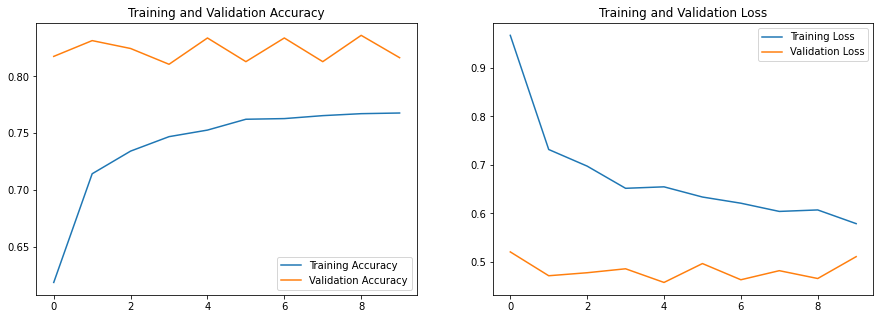

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [43]:
base_model.trainable = True
base_model.summary()

#lets take a look to see how many layers are inthe base model
print('Number of layers in the base model: ', len(base_model.layers))

#Fine-tune from this layer onwards
fine_tune_at = 100

#Freeze all layers before 'fine_tune_at' layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable=False

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 90, 90, 32)   864         ['input_3[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 90, 90, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 90, 90, 32)   0           ['bn_Conv1[0][

In [44]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 180, 180, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 180, 180, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 6, 6, 1280)       2257984   
 ional)                                                          
                                                           

In [45]:
initial_epochs = 10
fine_tune_epochs=10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_ds,
    epochs = total_epochs,
    initial_epoch = history.epoch[-1],
    validation_data=val_ds)

Epoch 10/20
109/109 [==============================] - 13s 74ms/step - loss: 0.5680 - accuracy: 0.7845 - val_loss: 0.4590 - val_accuracy: 0.8291
Epoch 11/20
109/109 [==============================] - 7s 67ms/step - loss: 0.5215 - accuracy: 0.7967 - val_loss: 0.4431 - val_accuracy: 0.8453
Epoch 12/20
109/109 [==============================] - 7s 67ms/step - loss: 0.5027 - accuracy: 0.8044 - val_loss: 0.4370 - val_accuracy: 0.8476
Epoch 13/20
109/109 [==============================] - 7s 67ms/step - loss: 0.4990 - accuracy: 0.8091 - val_loss: 0.4442 - val_accuracy: 0.8314
Epoch 14/20
109/109 [==============================] - 7s 67ms/step - loss: 0.4901 - accuracy: 0.8140 - val_loss: 0.4312 - val_accuracy: 0.8406
Epoch 15/20
109/109 [==============================] - 7s 67ms/step - loss: 0.4802 - accuracy: 0.8160 - val_loss: 0.4367 - val_accuracy: 0.8395
Epoch 16/20
109/109 [==============================] - 7s 67ms/step - loss: 0.4514 - accuracy: 0.8321 - val_loss: 0.4328 - val_accuracy

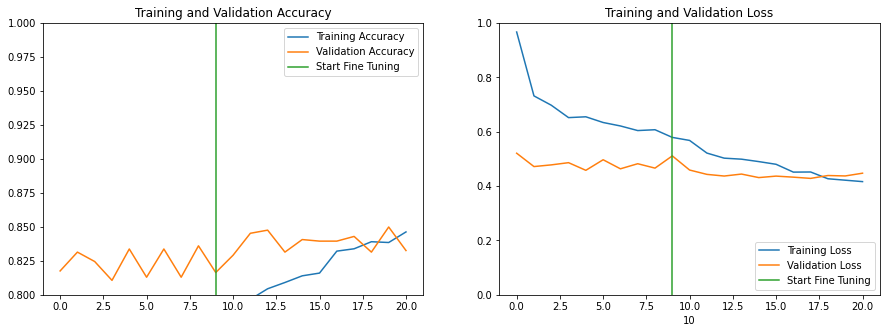

In [46]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs - 1, initial_epochs - 1],
         plt.ylim(), label = 'Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs - 1, initial_epochs - 1],
         plt.ylim(), label = 'Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

plt.xlabel(epochs)

plt.show()

In [47]:
new_data_dir = "gdrive/My Drive/vehicle_pictures"
batch_size = 32
img_height = 180
img_width = 180
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    new_data_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size)

class_names = test_dataset.class_names
print(class_names)

Found 20 files belonging to 4 classes.
['Bus', 'Motorcycle', 'Plane', 'train']


In [48]:
loss, accuracy = model.evaluate(test_dataset)
print('Test Accuracy: ', accuracy)

1/1 [==============================] - 0s 67ms/step - loss: 0.0696 - accuracy: 1.0000
Test Accuracy:  1.0
